In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

print("Tensorflow Version: {}".format(tf.__version__))
print("Tensorflow.Keras Version: {}".format(keras.__version__))

Tensorflow Version: 2.0.0-beta1
Tensorflow.Keras Version: 2.2.4-tf


In [0]:
def preprocess_image(img_path):
  img = cv2.imread(img_path)
  img = img[:,:,::-1]
  img = cv2.resize(img, (224,224))
  plt.imshow(img)
  plt.show()
  img = img / 255.0
  return img

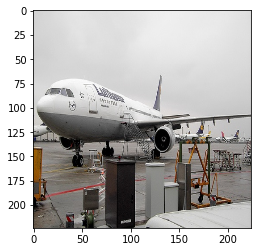

In [0]:
#cls_img_path = "/Users/jiankaiwang/devops/VOCdevkit/VOC2008/JPEGImages/2007_000648.jpg"
cls_img_path = "/Users/jiankaiwang/devops/VOCdevkit/VOC2008/JPEGImages/2007_000033.jpg"
assert os.path.exists(cls_img_path), "Image was not found."
img = preprocess_image(cls_img_path)
img = np.expand_dims(img, axis=0)
assert img.shape == (1,224,224,3), "Image shape was not allowed."

In [0]:
# SavedModel

## Using tf.saved_model APIs

In [0]:
saved_model_path = "/Users/jiankaiwang/devops/tfhub/imagene_mobilenet_v2_140_224_classification"
assert os.path.exists(saved_model_path), "Saved model path was not found."

loaded = tf.saved_model.load(saved_model_path, ['train'])
print(list(loaded.signatures.keys()))

['image_classification_with_bn_hparams', 'default', 'image_feature_vector_with_bn_hparams', 'image_classification', 'image_feature_vector']


In [0]:
all_ops = loaded.graph.get_operations()
for ops in all_ops[:10]:
    if ops.name[:4] == "save": continue
    print(ops.name)

hub_input/images
hub_input/Mul/y
hub_input/Mul
hub_input/Sub/y
hub_input/Sub
hub_hparams/batch_norm_momentum
MobilenetV2/input
MobilenetV2/Conv/weights/Initializer/truncated_normal/shape
MobilenetV2/Conv/weights/Initializer/truncated_normal/mean
MobilenetV2/Conv/weights/Initializer/truncated_normal/stddev


In [0]:
inputs = loaded.graph.get_tensor_by_name("hub_input/images:0")
outputs = loaded.graph.get_tensor_by_name("MobilenetV2/Logits/output:0")
print("Inputs: {}".format(inputs))
print("Outputs: {}".format(outputs))

Inputs: Tensor("hub_input/images:0", shape=(None, 224, 224, 3), dtype=float32)
Outputs: Tensor("MobilenetV2/Logits/output:0", shape=(None, 1001), dtype=float32)


In [0]:
model = loaded.signatures["default"]

In [0]:
img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
result = model(images=img_tensor)
result, np.argmax(result["default"].numpy())

({'default': <tf.Tensor: id=25025, shape=(1, 1001), dtype=float32, numpy=
  array([[ 0.18783015, -0.22686976,  0.22382739, ...,  0.11015037,
          -0.57388103,  0.3223241 ]], dtype=float32)>}, 819)

# Using TF2.Keras

### Whole Model

In [0]:
if saved_lastest_one:
  save_model(model, latest_model_path)  

In [0]:
model = load_model(
    latest_model_path,
    custom_objects={'Custom_Reshape': Custom_Reshape,
                    'yolov1_loss': yolov1_loss, 
                    'precision': precision, 
                    'sensitivity': sensitivity})  

### Export to SavedModel

### Architecture-only saving

#### dict-based saving

In [0]:
config = model.get_config()

In [0]:
reinitialization_model = keras.Model.from_config(
    config, 
    custom_objects={'Custom_Reshape': Custom_Reshape, 
        'yolov1_loss': yolov1_loss,
        'precision': precision,
        'sensitivity': sensitivity})

#### json-based saving

In [0]:
config_json = model.to_json()

In [0]:
reinitialization_model = keras.models.model_from_json(
    config_json, 
    custom_objects={'Custom_Reshape': Custom_Reshape, 
        'yolov1_loss': yolov1_loss,
        'precision': precision,
        'sensitivity': sensitivity})

In [0]:
SavedModel_path = os.path.join(".", "tinyyolo_test")
keras.experimental.export_saved_model(
    model, 
    SavedModel_path, 
    custom_objects={
        'Custom_Reshape': Custom_Reshape, 
        'yolov1_loss': yolov1_loss, 
        'precision': precision,
        'sensitivity': sensitivity})

In [0]:
model = keras.experimental.load_from_saved_model(
    SavedModel_path, 
    custom_objects={
        'Custom_Reshape': Custom_Reshape, 
        'yolov1_loss': yolov1_loss,
        'precision': precision,
        'sensitivity': sensitivity})

### Weights-only saving

In [0]:
weights = model.get_weights()

You can combine two parts, the model configure (get_config()/from_config()) and the model status (get_weights()/set_weights()), to recreate the model.
However, you have to call compile() again before using the model for training.

In [0]:
config = model.get_config()
weights = model.get_weights()

new_model = keras.Model.from_config(
    config, 
    custom_objects={
        'Custom_Reshape': Custom_Reshape, 
        'yolov1_loss': yolov1_loss,
        'precision': precision,
        'sensitivity': sensitivity})
new_model.set_weights(weights)

### Both architecture and weights

Save to the disk (local files).

In [0]:
json_config = model.to_json()
model_arch_path = os.path.join(".", "models","arch.json")
with open(model_arch_path, "w") as fout:
  fout.write(json_config)

model_weights_path = os.path.join(".", "models","weights.h5")
model.save_weights(model_weights_path)

# save in SavedModel model
model_weights_path_tf = os.path.join(".", "model", "weights_tf")
model.save_weights(model_weights_path_tf, save_format="tf")

Load both architecture and weights from the disk.



In [0]:
json_config_local = ""
with open(model_arch_path, "r") as fin:
  json_config_local = fin.read()
new_model = keras.models.model_from_json(
    json_config_local, 
    custom_objects={
        'Custom_Reshape': Custom_Reshape, 
        'yolov1_loss': yolov1_loss,
        'precision': precision,
        'sensitivity': sensitivity})
new_model.load_weights(model_weights_path)